In [205]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [206]:
import sys
sys.path.append('../')

In [246]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib.cm
from utils import Trade, Resources, Goal
from collections import defaultdict

In [247]:
exp_path = "../.logs/1698480633466"
# exp_path = "../.logs/1698477062823"
with open(os.path.join(exp_path,"state.json")) as f:
    exp_state = json.load(f)

In [248]:
def load_states(paths):
    states = {}
    for exp_path in paths:
        with open(os.path.join(exp_path,"state.json")) as f:
            states[exp_path] = json.load(f)
    return states

In [249]:
def compute_metric_from_state(exp_state, metric_fn, metric_store: defaultdict):
    for agent_id, agent_state in enumerate(exp_state):
         metric_fn(agent_id, agent_state, metric_store)
    return metric_store

def agent_proposal_utility_fn(agent_id, agent_state, metric_store):
    for state in agent_state[1:]:
        if state['proposed_trade'] != "None":
            # convert string into objects
            resources = Resources.from_string(state['resources'])
            goals = Goal.from_string(state['goals'])
            proposed_trade = Trade.from_string(state['proposed_trade'])
            # mini hack to get the right sign
            marginal_utility = goals-resources if agent_id == 0 else resources-goals
            marginal_utility.resource_dict = { k : max(v,0) for k,v in  marginal_utility.resource_dict.items()}
            metric_store[agent_id].append(proposed_trade.utility(resources, goals, dir=agent_id ))

def agent_success_fn(agent_id, agent_state, metric_store):
    state = agent_state[-1]
    goals = Goal.from_string(state['goals'])
    resources = Resources.from_string(state['resources'])
    goal_reached = goals.goal_reached(resources)
    metric_store[agent_id] = goal_reached



In [250]:
def agent_proposal_utility(states):
    return [compute_metric_from_state(_, agent_proposal_utility_fn, defaultdict(list)) for _ in states.values()]

def agent_success(states):
    return [compute_metric_from_state(_, agent_success_fn, defaultdict(bool)) for _ in states.values()]

def agent_average_success(states):
    success = agent_success(states)
    return { k: sum([trial[k] for trial in success])/len(success)  for k in success[0].keys() }
                          

In [251]:
paths = [
    "../.logs/1698477062823",
    "../.logs/1698480633466",
    "../.logs/1698481270492",
    "../.logs/1698482232830",
    "../.logs/1698495880941",
    "../.logs/1698496634422",
    "../.logs/1698501268796"
]
states = load_states(paths)

In [252]:
proposal_utilities = agent_proposal_utility(states)
success = agent_success(states)
avg_success = agent_average_success(states)

Text(0.5, 1.0, 'Trade Success Rate')

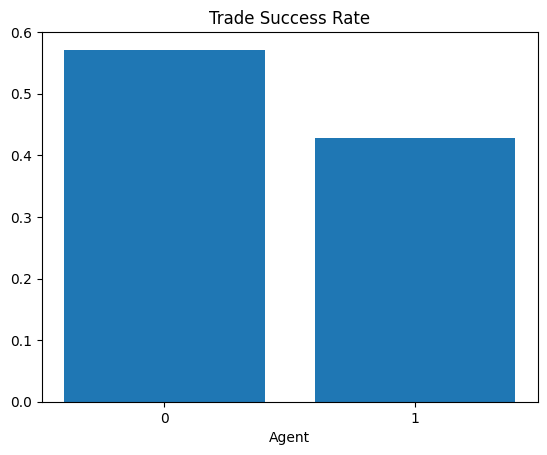

In [253]:
plt.bar(avg_success.keys(), avg_success.values(), tick_label=list(avg_success.keys()))
plt.xlabel('Agent')
plt.title('Trade Success Rate')

Text(0.5, 1.0, 'Trade Trajectories')

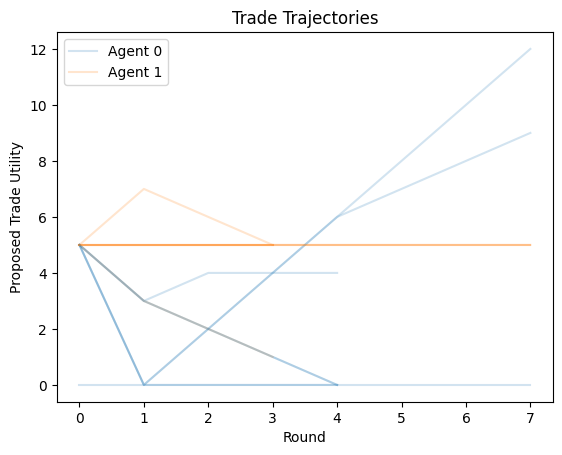

In [254]:
color = matplotlib.cm.datad['tab10']['listed']
for util in proposal_utilities:
    for idx, _ in enumerate(util.values()):
        plt.plot(_, color=color[idx], alpha=0.2, linewidth=1.5)

plt.legend(['Agent 0', 'Agent 1'])
plt.xlabel('Round')
plt.ylabel('Proposed Trade Utility')
# plt.yscale('log')
plt.title("Trade Trajectories")

In [258]:
[ _[0] for _ in proposal_utilities]

[[5.0, 3.0, 2.0, 1.0, 0.0],
 [5.0, 0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0],
 [5.0, 3.0, 4.0, 4.0, 4.0],
 [5.0, 0.0, 2.0, 4.0, 6.0, 7.0, 8.0, 9.0],
 [5.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [5.0, 3.0, 2.0, 1.0, 0.0]]